# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from utils import decode_missing_values
from utils import ratio_missing

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# magic word for producing visualizations in notebook
%matplotlib inline

pd.set_option('display.max_columns', 300)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

Setting up a ETL pipeline starting with the extract step.

### Extract

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
top_level_attr_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1, dtype=str)
attr_mapping_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, dtype=str)
del top_level_attr_df['Unnamed: 0']
del attr_mapping_df['Unnamed: 0']

<b> Getting familiar with the data</b>

In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,...,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KK_KUNDENTYP,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RET

In [5]:
customers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 369 columns):
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float6

In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,...,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KK_KUNDENTYP,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_H

In [7]:
azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float6

In [8]:
print('custormer dataset shape:{}'.format(customers.shape))
print('azdias dataset shape:{}'.format(azdias.shape))

custormer dataset shape:(191652, 369)
azdias dataset shape:(891221, 366)


In [9]:
top_level_attr_df.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [10]:
attr_mapping_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


### Cleaning

In [11]:
azdias_clean = azdias.copy()

In [12]:
azdias_clean['LNR'].duplicated().sum()
azdias_clean['LNR'].isnull().sum()

0

From the data it seems that LNR is a unique identifier for each observation. Therefore we will set it as the index of the dataframes.

In [13]:
azdias_clean.set_index('LNR', inplace=True)

Since no time based analysis will be made EINGEFUEGT_AM attribute can be removed.

In [14]:
azdias_clean.drop('EINGEFUEGT_AM', axis=1, inplace=True)

- Before preceeding with analysing the features, first we check if all the features are included in the DIAS Information Levels - Attributes 2017.xlsx and DIAS Attributes - Values 2017.xlsx files.

In [15]:
all_attributes = set(attr_mapping_df[attr_mapping_df['Attribute'].notnull()]['Attribute'].unique()).union(set(top_level_attr_df['Attribute'].unique()))

In [16]:
attributes_not_explained = azdias_clean.columns[~azdias_clean.columns.isin(all_attributes)] # columns not in attribute explanation files
print(attributes_not_explained)

Index(['AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER',
       'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5',
       'CJT_TYP_6', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
       'D19_GARTEN', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
       'D

These attributes will be removed since they cannot be known what they are.

In [17]:
azdias_clean.drop(attributes_not_explained, axis=1, inplace=True)

In [18]:
azdias_clean.shape

(891221, 276)

- Correcting the data types

In [19]:
azdias_clean['CAMEO_DEUG_2015'].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

CAMEO_DEUG_2015 attribute shows issues with incorrect data

In [20]:
azdias_clean['CAMEO_DEUG_2015'] = np.where(azdias_clean['CAMEO_DEUG_2015']=='X', np.NaN, azdias_clean['CAMEO_DEUG_2015'])

In [21]:
azdias_clean['CAMEO_DEUG_2015'] = azdias_clean['CAMEO_DEUG_2015'].astype(float)

- Find and replace the feature values encoded as unkown with NaN

In [22]:
attr_mapping_clean = attr_mapping_df.copy()

In [23]:
attr_mapping_clean.fillna(method='ffill', inplace=True)

In [24]:
unknown_mapping = attr_mapping_clean[attr_mapping_clean['Meaning']=='unknown'].set_index('Attribute')['Value']
attr_mapping_clean.drop(attr_mapping_clean[attr_mapping_clean['Meaning']=='unknown'].index, axis=0, inplace=True)

In [25]:
azdias_clean = decode_missing_values(azdias_clean, unknown_mapping)

[========================================================================] 100%


In [26]:
azdias_clean.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL

- Investigate how many data are missing and where

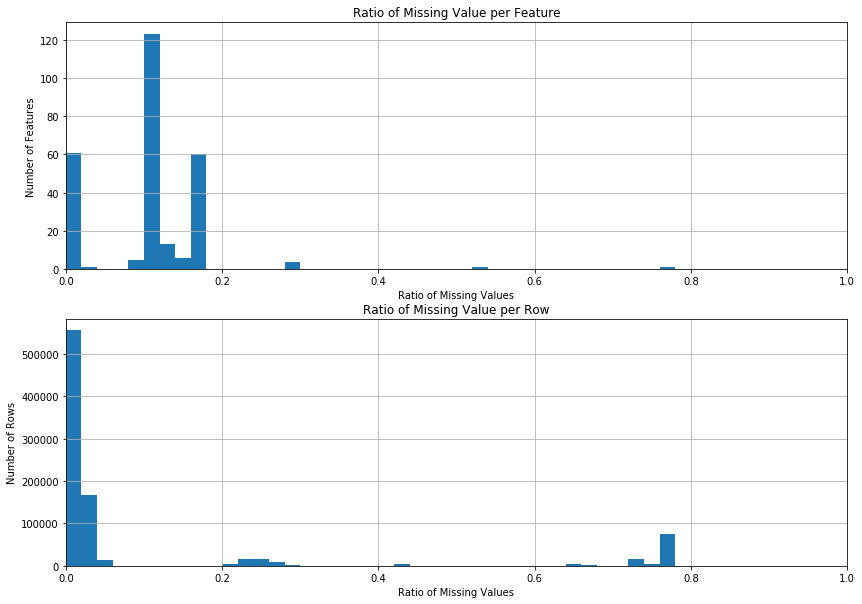

In [27]:
ratio_missing_rows, ratio_missing_cols = ratio_missing(azdias_clean, plot=True)

Features containing missing values above 20% is removed. This threshold is selected to keep the maximum available features with low missing value ratio. <br>

Rows containing missing values above 4% will also be dropped.

In [31]:
azdias_clean = remove_above_percent(azdias_clean, ratio_missing_cols, 0.2, axis=1)
azdias_clean = remove_above_percent(azdias_clean, ratio_missing_rows, 0.4, axis=0)

In [32]:
null_values = azdias_clean.isnull()
print('Current Shape of dataframe: {}'.format(azdias_clean.shape))
print('Number of missing values: {}'.format(null_values.sum().sum()))
print('Number of rows with missing values: {}'.format(np.sum([null_values.sum(axis=1)>0])))
print('Number of attributes with missing values: {}'.format(np.sum([null_values.sum(axis=0)>0])))

Current Shape of dataframe: (785756, 269)
Number of missing values: 3500113
Number of rows with missing values: 171863
Number of attributes with missing values: 207


In [33]:
np.sum([null_values.sum(axis=1)>0])/azdias_clean.shape[0]

0.21872311506370934

Dropping the data points containing missing values will cost about 22% of the data. To compensate for this loss since most of the data is qualitative, classification methods can be used to impute data to the missing values and for quantitative data, mean or median of the data can be used.<br>

At this point it does not look too cost effective (time consumption wise) to use machine learning for imputation. Therefore the data points with missing values will be dropped.

In [34]:
azdias_clean.drop(azdias_clean[null_values.sum(axis=1)>0].index, axis=0, inplace=True)

In [35]:
azdias_clean.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [36]:
print('Final shape of the azdias data: {}'.format(azdias_clean.shape))

Final shape of the azdias data: (613893, 269)


- Clean the customers data using the kept features in azdias

In [37]:
features_kept = azdias_clean.columns
customers_clean = customers[['LNR', *features_kept]].copy()
customers_clean.set_index('LNR', inplace=True)
customers_clean['CAMEO_DEUG_2015'] = np.where(customers_clean['CAMEO_DEUG_2015']=='X', np.NaN, customers_clean['CAMEO_DEUG_2015'])

In [38]:
customers_clean = decode_missing_values(customers_clean)

[========================================================================] 100%


In [39]:
null_values_customers = customers_clean.isnull()
print('Current Shape of dataframe: {}'.format(customers_clean.shape))
print('Number of missing values: {}'.format(null_values_customers.sum().sum()))
print('Number of rows with missing values: {}'.format(np.sum([null_values_customers.sum(axis=1)>0])))
print('Number of attributes with missing values: {}'.format(np.sum([null_values_customers.sum(axis=0)>0])))

Current Shape of dataframe: (191652, 269)
Number of missing values: 10980753
Number of rows with missing values: 76599
Number of attributes with missing values: 218


In [40]:
customers_clean.drop(customers_clean[null_values_customers.sum(axis=1)>0].index, axis=0, inplace=True)

In [41]:
customers_clean.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [42]:
print('Final shape of the customers data: {}'.format(customers_clean.shape))

Final shape of the customers data: (115053, 269)


Create a checkpoint

In [43]:
azdias_clean.to_pickle('azdias_clean.pkl')
customers_clean.to_pickle('customers_clean.pkl')
attr_mapping_clean.to_pickle('attr_mapping_clean.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Preprocessing

Starting from the previous checkpoint

In [22]:
azdias_preprocessed = pd.read_pickle('azdias_clean.pkl')
customers_preprocessed = pd.read_pickle('customers_clean.pkl')
attr_mapping_clean = pd.read_pickle('attr_mapping_clean.pkl')

The continuous attributes have been manually extracted from the DIAS Attributes - Values 2017.xlsx file

In [45]:
numeric_features = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']
qualitative_features = list(set(attr_mapping_clean['Attribute'].unique()).difference(set(numeric_features)))

All the qualitative features need to be encoded for machine learning,

This will be done as one hot encoding.

In [46]:
# filtering the qualitative features that are in the dataset
qualitative_features_used = [x for x in azdias_preprocessed.columns if x in(qualitative_features)]

In [47]:
qualitative_features_mapping = attr_mapping_clean[attr_mapping_clean['Attribute'].isin(qualitative_features_used)]

Before going through the one hot encoding process, lets investigate how the categories are seperated

In [48]:
granularity = qualitative_features_mapping['Attribute'].value_counts().sort_values(ascending=False)
granularity.head(20)

CAMEO_DEU_2015               44
LP_LEBENSPHASE_FEIN          40
ALTER_HH                     22
PRAEGENDE_JUGENDJAHRE        15
LP_LEBENSPHASE_GROB          12
GFK_URLAUBERTYP              12
LP_FAMILIE_GROB              11
LP_FAMILIE_FEIN              11
D19_BANKEN_ONLINE_DATUM      10
D19_VERSAND_ONLINE_DATUM     10
D19_GESAMT_ONLINE_DATUM      10
D19_GESAMT_OFFLINE_DATUM     10
D19_BANKEN_DATUM             10
D19_TELKO_OFFLINE_DATUM      10
D19_TELKO_DATUM              10
D19_TELKO_ONLINE_DATUM       10
LP_STATUS_FEIN               10
D19_VERSAND_DATUM            10
D19_VERSAND_OFFLINE_DATUM    10
LP_STATUS_GROB               10
Name: Attribute, dtype: int64

It can be seen that there are features which have very high granurality then others. To reduce computational processing effort features which have above 10 categories will be dropped from the data.

In [49]:
azdias_preprocessed.drop(granularity[granularity>10].index, axis=1, inplace=True)
customers_preprocessed.drop(granularity[granularity>10].index, axis=1, inplace=True)
qualitative_features_mapping = qualitative_features_mapping.drop(qualitative_features_mapping[qualitative_features_mapping['Attribute'].isin(granularity[granularity>10].index)].index)

In [27]:
def categorize(df, categorical_mapping):
    
    categorized_df = df.copy()
    
    feature_list = categorical_mapping['Attribute'].unique()
    
    cnter = 0
    bar = progressbar.ProgressBar(maxval=len(feature_list)+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for feat in feature_list:
        
        try:
            categories = categorical_mapping[categorical_mapping['Attribute']==feat]['Value'].values.astype(int)
            categorized_df[feat] = categorized_df[feat].astype(int)
        except:
            categories = categorical_mapping[categorical_mapping['Attribute']==feat]['Value'].values
            
        # print('feat', feat)
        # print('categories', categories)
        # print('features in dataset', categorized_df[feat].unique())
        
        dummies = pd.get_dummies(categorized_df[feat], drop_first=False, prefix=feat, prefix_sep='_d_')
        
        not_categorized = np.setdiff1d(categories, categorized_df[feat].unique())
        if not_categorized is not None:
            for ncat in not_categorized:
                dummies[(feat+'_d_'+str(ncat))] = 0
            
        try:
            categorized_df = categorized_df.join(dummies)
            categorized_df.drop(feat, axis=1, inplace=True)
        except:
            print('Error during encoding')
            print('Error feature: {}'.format(feat))
            print('Encoded top 10 rows as:')
            print(dummies.head(10))
            break
    
        # Update the progress bar
        cnter+=1 
        bar.update(cnter)
        
    bar.finish()

    return categorized_df

In [51]:
azdias_preprocessed = categorize(azdias_preprocessed, qualitative_features_mapping)

[========================================================================] 100%


Nest step for preprocessing is Feature Scaling. In this step the data will be standardized

In [52]:
azdias_preprocessed.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 613893 entries, 910220 to 825787
Data columns (total 1475 columns):
ANZ_HAUSHALTE_AKTIV                float64
ANZ_HH_TITEL                       float64
ANZ_PERSONEN                       float64
ANZ_TITEL                          float64
ARBEIT                             float64
D19_VERSI_DATUM                    int64
D19_VERSI_OFFLINE_DATUM            int64
D19_VERSI_ONLINE_DATUM             int64
GEBURTSJAHR                        int64
KBA13_ANZAHL_PKW                   float64
MIN_GEBAEUDEJAHR                   float64
ALTERSKATEGORIE_GROB_d_1           uint8
ALTERSKATEGORIE_GROB_d_2           uint8
ALTERSKATEGORIE_GROB_d_3           uint8
ALTERSKATEGORIE_GROB_d_4           uint8
ALTERSKATEGORIE_GROB_d_9           int64
ANREDE_KZ_d_1                      uint8
ANREDE_KZ_d_2                      uint8
BALLRAUM_d_1                       uint8
BALLRAUM_d_2                       uint8
BALLRAUM_d_3                       uint8
BALLRAU

In [53]:
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_preprocessed)

Going thorugh the same preprocessing steps for the customers data.

In [54]:
customers_preprocessed = categorize(customers_preprocessed, qualitative_features_mapping)
customers_preprocessed.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115053 entries, 9626 to 148883
Data columns (total 1475 columns):
ANZ_HAUSHALTE_AKTIV                float64
ANZ_HH_TITEL                       float64
ANZ_PERSONEN                       float64
ANZ_TITEL                          float64
ARBEIT                             float64
D19_VERSI_DATUM                    int64
D19_VERSI_OFFLINE_DATUM            int64
D19_VERSI_ONLINE_DATUM             int64
GEBURTSJAHR                        int64
KBA13_ANZAHL_PKW                   float64
MIN_GEBAEUDEJAHR                   float64
ALTERSKATEGORIE_GROB_d_1           uint8
ALTERSKATEGORIE_GROB_d_2           uint8
ALTERSKATEGORIE_GROB_d_3           uint8
ALTERSKATEGORIE_GROB_d_4           uint8
ALTERSKATEGORIE_GROB_d_9           int64
ANREDE_KZ_d_1                      uint8
ANREDE_KZ_d_2                      uint8
BALLRAUM_d_1                       uint8
BALLRAUM_d_2                       uint8
BALLRAUM_d_3                       uint8
BALLRAUM_

In [55]:
customers_scaled = scaler.transform(customers_preprocessed)

Create a checkpoint

In [56]:
azdias_preprocessed.to_pickle('azdias_preprocessed.pkl')
customers_preprocessed.to_pickle('customers_preprocessed.pkl')

with open('azdias_scaled.pkl','wb') as f:
    pickle.dump(azdias_scaled, f, protocol=4)
    
with open('customers_scaled.pkl','wb') as f:
    pickle.dump(customers_scaled, f, protocol=4)

with open('scaler.pkl','wb') as f:
    pickle.dump(scaler, f)

### Clustering
At this point the data is ready for machine learning methods. For clustering k-means method will be used.

While using k-means due to high computing time and high resources required, the mini batch k-Means method is preferred instead.

In [57]:
azdias_preprocessed = pd.read_pickle('azdias_preprocessed.pkl')
customers_preprocessed = pd.read_pickle('customers_preprocessed.pkl')
    
with open('azdias_scaled.pkl','rb') as f:
    azdias_scaled = pickle.load(f)
    
with open('customers_scaled.pkl','rb') as f:
    customers_scaled = pickle.load(f)
    
with open('scaler.pkl','rb') as f:
    scaler = pickle.load(f)

In [62]:
sample_ind = np.random.choice(azdias_scaled.shape[0], size=40000, replace=False)
clustering_subset = azdias_scaled[sample_ind]

In [63]:
n_clusters = 20
cnter = 0
bar = progressbar.ProgressBar(maxval=n_clusters+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

score = []
clusters = np.arange(2, n_clusters+1)
for i in clusters:
    k_means = MiniBatchKMeans(n_clusters=i)
    cluster = k_means.fit(clustering_subset)
    score.append(cluster.score(clustering_subset))
    cnter+=1 
    bar.update(cnter)
    
bar.finish()

[========================================================================] 100%


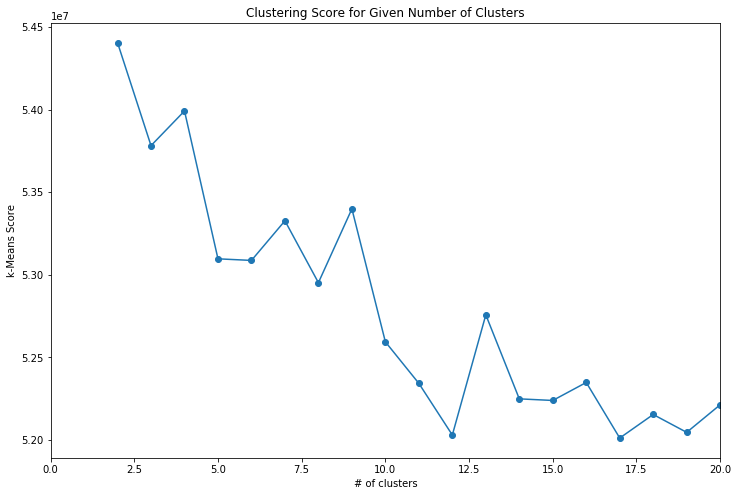

In [64]:
plt.figure(figsize=(12,8))
plt.plot(clusters, np.absolute(score), marker='o')
plt.xlabel('# of clusters');
plt.ylabel('k-Means Score');
plt.title('Clustering Score for Given Number of Clusters');
plt.xlim((0,20));

From the above plot it can be seen that after 10 clusters the k-Means score starts to flatten. This indicates that 15 clusters is a good choise for progressing further with the analysis.

In [65]:
n_selected_cluster = 10
k_means_selected = MiniBatchKMeans(n_selected_cluster, verbose=10)
azdias_clusters = k_means_selected.fit(azdias_scaled) # clustering azdias data with selected number of clusters

Init 1/3 with method: k-means++
Inertia for init 1/3: 377722.158872
Init 2/3 with method: k-means++
Inertia for init 2/3: 373463.525920
Init 3/3 with method: k-means++
Inertia for init 3/3: 377488.539989
Minibatch iteration 1/613900: mean batch inertia: 1277.903439, ewa inertia: 1277.903439 
Minibatch iteration 2/613900: mean batch inertia: 1332.751817, ewa inertia: 1277.921308 
Minibatch iteration 3/613900: mean batch inertia: 1354.961745, ewa inertia: 1277.946407 
Minibatch iteration 4/613900: mean batch inertia: 1270.836504, ewa inertia: 1277.944090 
Minibatch iteration 5/613900: mean batch inertia: 1373.376797, ewa inertia: 1277.975181 
Minibatch iteration 6/613900: mean batch inertia: 1489.325511, ewa inertia: 1278.044037 
Minibatch iteration 7/613900: mean batch inertia: 1347.666946, ewa inertia: 1278.066719 
Minibatch iteration 8/613900: mean batch inertia: 1371.846818, ewa inertia: 1278.097272 
Minibatch iteration 9/613900: mean batch inertia: 1320.052615, ewa inertia: 1278.110

In [66]:
azdias_clusters = k_means_selected.predict(azdias_scaled) # clustering azdias data with the trained clusterer
customers_clusters = k_means_selected.predict(customers_scaled) # clustering customers data with the trained clusterer

Computing label assignment and total inertia
Computing label assignment and total inertia


Analysing the results of clustering

In [67]:
cluster_centers_df = pd.DataFrame(scaler.inverse_transform(k_means_selected.cluster_centers_), columns=azdias_preprocessed.columns)

In [68]:
clustered_azdias = azdias_preprocessed.copy()
clustered_customers = customers_preprocessed.copy()

clustered_azdias['Cluster'] = azdias_clusters
clustered_customers['Cluster'] = customers_clusters

Save the data and the trained clustering model

In [78]:
clustered_azdias.to_pickle('clustered_azdias.pkl')
clustered_customers.to_pickle('clustered_customers.pkl')
cluster_centers_df.to_pickle('cluster_centers_df.pkl')

with open('k_means_selected.pkl','wb') as f:
    pickle.dump(k_means_selected, f)

In [70]:
azdias_cluster_ratio = clustered_azdias['Cluster'].value_counts()/clustered_azdias.shape[0]
customers_cluster_ratio = clustered_customers['Cluster'].value_counts()/clustered_customers.shape[0]

ratios_df = pd.DataFrame({'azdias':azdias_cluster_ratio, 'customers':customers_cluster_ratio})

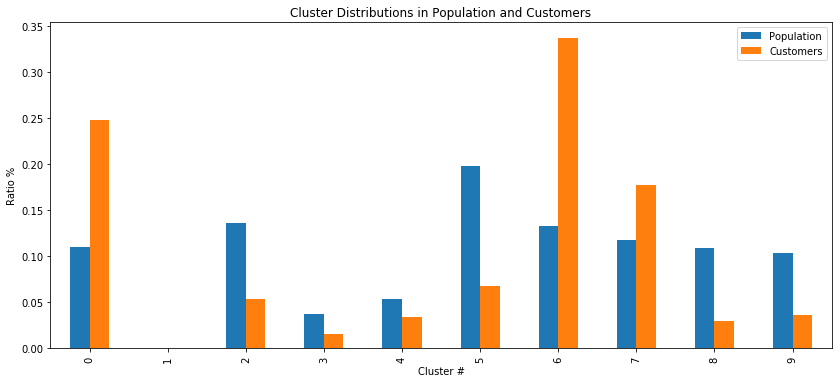

In [71]:
ratios_df.plot(kind='bar', figsize=(14,6))
plt.legend(('Population', 'Customers'));
plt.title(('Cluster Distributions in Population and Customers'));
plt.xlabel('Cluster #');
plt.ylabel('Ratio %');
plt.show()

In [74]:
customers_cluster_ratio

6    0.337401
0    0.248016
7    0.177423
5    0.067960
2    0.053714
9    0.036175
4    0.033698
8    0.029526
3    0.015628
1    0.000461
Name: Cluster, dtype: float64

It can be seen that the customers are mostly defined by cluster 6, 0 and 7. Clusters 1 is the least represented customers nearing 0%.

In [77]:
cluster_centers_df.loc[[6,0,7]]

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR,ALTERSKATEGORIE_GROB_d_1,ALTERSKATEGORIE_GROB_d_2,ALTERSKATEGORIE_GROB_d_3,ALTERSKATEGORIE_GROB_d_4,ALTERSKATEGORIE_GROB_d_9,ANREDE_KZ_d_1,ANREDE_KZ_d_2,BALLRAUM_d_1,BALLRAUM_d_2,BALLRAUM_d_3,BALLRAUM_d_4,BALLRAUM_d_5,BALLRAUM_d_6,BALLRAUM_d_7,CAMEO_DEUG_2015_d_1,CAMEO_DEUG_2015_d_2,CAMEO_DEUG_2015_d_3,CAMEO_DEUG_2015_d_4,CAMEO_DEUG_2015_d_5,CAMEO_DEUG_2015_d_6,CAMEO_DEUG_2015_d_7,CAMEO_DEUG_2015_d_8,CAMEO_DEUG_2015_d_9,CJT_GESAMTTYP_d_1,CJT_GESAMTTYP_d_2,CJT_GESAMTTYP_d_3,CJT_GESAMTTYP_d_4,CJT_GESAMTTYP_d_5,CJT_GESAMTTYP_d_6,D19_BANKEN_ANZ_12_d_0,D19_BANKEN_ANZ_12_d_1,D19_BANKEN_ANZ_12_d_2,D19_BANKEN_ANZ_12_d_3,D19_BANKEN_ANZ_12_d_4,D19_BANKEN_ANZ_12_d_5,D19_BANKEN_ANZ_12_d_6,D19_BANKEN_ANZ_24_d_0,D19_BANKEN_ANZ_24_d_1,D19_BANKEN_ANZ_24_d_2,D19_BANKEN_ANZ_24_d_3,D19_BANKEN_ANZ_24_d_4,D19_BANKEN_ANZ_24_d_5,D19_BANKEN_ANZ_24_d_6,D19_BANKEN_DATUM_d_1,D19_BANKEN_DATUM_d_2,D19_BANKEN_DATUM_d_3,D19_BANKEN_DATUM_d_4,D19_BANKEN_DATUM_d_5,D19_BANKEN_DATUM_d_6,D19_BANKEN_DATUM_d_7,D19_BANKEN_DATUM_d_8,D19_BANKEN_DATUM_d_9,D19_BANKEN_DATUM_d_10,D19_BANKEN_OFFLINE_DATUM_d_1,D19_BANKEN_OFFLINE_DATUM_d_2,D19_BANKEN_OFFLINE_DATUM_d_3,D19_BANKEN_OFFLINE_DATUM_d_4,D19_BANKEN_OFFLINE_DATUM_d_5,D19_BANKEN_OFFLINE_DATUM_d_6,D19_BANKEN_OFFLINE_DATUM_d_7,D19_BANKEN_OFFLINE_DATUM_d_8,D19_BANKEN_OFFLINE_DATUM_d_9,D19_BANKEN_OFFLINE_DATUM_d_10,D19_BANKEN_ONLINE_DATUM_d_1,D19_BANKEN_ONLINE_DATUM_d_2,D19_BANKEN_ONLINE_DATUM_d_3,D19_BANKEN_ONLINE_DATUM_d_4,D19_BANKEN_ONLINE_DATUM_d_5,D19_BANKEN_ONLINE_DATUM_d_6,D19_BANKEN_ONLINE_DATUM_d_7,D19_BANKEN_ONLINE_DATUM_d_8,D19_BANKEN_ONLINE_DATUM_d_9,D19_BANKEN_ONLINE_DATUM_d_10,D19_GESAMT_ANZ_12_d_0,D19_GESAMT_ANZ_12_d_1,D19_GESAMT_ANZ_12_d_2,D19_GESAMT_ANZ_12_d_3,D19_GESAMT_ANZ_12_d_4,D19_GESAMT_ANZ_12_d_5,D19_GESAMT_ANZ_12_d_6,D19_GESAMT_ANZ_24_d_0,D19_GESAMT_ANZ_24_d_1,D19_GESAMT_ANZ_24_d_2,D19_GESAMT_ANZ_24_d_3,D19_GESAMT_ANZ_24_d_4,D19_GESAMT_ANZ_24_d_5,D19_GESAMT_ANZ_24_d_6,D19_GESAMT_DATUM_d_1,D19_GESAMT_DATUM_d_2,D19_GESAMT_DATUM_d_3,D19_GESAMT_DATUM_d_4,D19_GESAMT_DATUM_d_5,D19_GESAMT_DATUM_d_6,D19_GESAMT_DATUM_d_7,D19_GESAMT_DATUM_d_8,D19_GESAMT_DATUM_d_9,D19_GESAMT_DATUM_d_10,D19_GESAMT_OFFLINE_DATUM_d_1,D19_GESAMT_OFFLINE_DATUM_d_2,D19_GESAMT_OFFLINE_DATUM_d_3,D19_GESAMT_OFFLINE_DATUM_d_4,D19_GESAMT_OFFLINE_DATUM_d_5,D19_GESAMT_OFFLINE_DATUM_d_6,D19_GESAMT_OFFLINE_DATUM_d_7,D19_GESAMT_OFFLINE_DATUM_d_8,D19_GESAMT_OFFLINE_DATUM_d_9,D19_GESAMT_OFFLINE_DATUM_d_10,D19_GESAMT_ONLINE_DATUM_d_1,D19_GESAMT_ONLINE_DATUM_d_2,D19_GESAMT_ONLINE_DATUM_d_3,D19_GESAMT_ONLINE_DATUM_d_4,D19_GESAMT_ONLINE_DATUM_d_5,D19_GESAMT_ONLINE_DATUM_d_6,D19_GESAMT_ONLINE_DATUM_d_7,D19_GESAMT_ONLINE_DATUM_d_8,D19_GESAMT_ONLINE_DATUM_d_9,D19_GESAMT_ONLINE_DATUM_d_10,D19_TELKO_ANZ_12_d_0,D19_TELKO_ANZ_12_d_1,D19_TELKO_ANZ_12_d_2,D19_TELKO_ANZ_12_d_3,D19_TELKO_ANZ_12_d_4,D19_TELKO_ANZ_12_d_5,D19_TELKO_ANZ_12_d_6,D19_TELKO_ANZ_24_d_0,D19_TELKO_ANZ_24_d_1,D19_TELKO_ANZ_24_d_2,D19_TELKO_ANZ_24_d_3,D19_TELKO_ANZ_24_d_4,D19_TELKO_ANZ_24_d_5,D19_TELKO_ANZ_24_d_6,D19_TELKO_DATUM_d_1,D19_TELKO_DATUM_d_2,D19_TELKO_DATUM_d_3,D19_TELKO_DATUM_d_4,D19_TELKO_DATUM_d_5,D19_TELKO_DATUM_d_6,D19_TELKO_DATUM_d_7,D19_TELKO_DATUM_d_8,...,REGIOTYP_d_1,REGIOTYP_d_2,REGIOTYP_d_3,REGIOTYP_d_4,REGIOTYP_d_5,REGIOTYP_d_6,REGIOTYP_d_7,RELAT_AB_d_1,RELAT_AB_d_2,RELAT_AB_d_3,RELAT_AB_d_4,RELAT_AB_d_5,RETOURTYP_BK_S_d_1,RETOURTYP_BK_S_d_2,RETOURTYP_BK_S_d_3,RETOURTYP_BK_S_d_4,RETOURTYP_BK_S_d_5,SEMIO_DOM_d_1,SEMIO_DOM_d_2,SEMIO_DOM_d_3,SEMIO_DOM_d_4,SEMIO_DOM_d_5,SEMIO_DOM_d_6,SEMIO_DOM_d_7,SEMIO_ERL_d_1,SEMIO_ERL_d_2,SEMIO_ERL_d_3,SEMIO_ERL_d_4,SEMIO_ERL_d_5,SEMIO_ERL_d_6,SEMIO_ERL_d_7,SEMIO_FAM_d_1,SEMIO_FAM_d_2,SEMIO_FAM_d_3,SEMIO_FAM_d_4,SEMIO_FAM_d_5,SEMIO_FAM_d_6,SEMIO_FAM_d_7,SEMIO_KAEM_d_1,SEMIO_KAEM_d_2,SEMIO_KAEM_d_3,SEMIO_KAEM_d_4,SEMIO_KAEM_d_5,SEMIO_KAEM_d_6,SEMIO_KAEM_d_7,SEMIO

## Finalized Cleaning, Preoprocessing and Clustering Functions

In [28]:
def clean_ref_data(df, attr_mapping_df, top_level_attr_df, missing_cols_thresh=0.2, missing_rows_thresh=0.4):
    '''
    
    '''
    
    df_filtered = df.copy()
    
    print('Setting LNR as index:')
    df_filtered.set_index('LNR', inplace=True)
    df_filtered.drop('EINGEFUEGT_AM', axis=1, inplace=True)
    
    print('Removing attriubtes that are not explained:')
    all_attributes = set(attr_mapping_df[attr_mapping_df['Attribute'].notnull()]['Attribute'].unique()).union(set(top_level_attr_df['Attribute'].unique()))
    attributes_not_explained = df_filtered.columns[~df_filtered.columns.isin(all_attributes)] # columns not in attribute explanation files
    df_filtered.drop(attributes_not_explained, axis=1, inplace=True)
    
    print('Correcting issues found in CAMEO_DEUG_2015:')
    df_filtered['CAMEO_DEUG_2015'] = np.where(df_filtered['CAMEO_DEUG_2015']=='X', np.NaN, df_filtered['CAMEO_DEUG_2015'])
    df_filtered['CAMEO_DEUG_2015'] = df_filtered['CAMEO_DEUG_2015'].astype(float)
    
    attr_mapping_clean = attr_mapping_df.copy()
    attr_mapping_clean.fillna(method='ffill', inplace=True)
    unknown_mapping = attr_mapping_clean[attr_mapping_clean['Meaning']=='unknown'].set_index('Attribute')['Value']
    attr_mapping_clean.drop(attr_mapping_clean[attr_mapping_clean['Meaning']=='unknown'].index, axis=0, inplace=True)
    
    print('Decoding and converting missing values to NaN:')
    df_filtered = decode_missing_values(df_filtered, unknown_mapping=unknown_mapping)
    ratio_missing_rows, ratio_missing_cols = ratio_missing(df_filtered, plot=False)
    
    print('Removing missing values according to row and collumn thresholds:')
    df_filtered = remove_above_percent(df_filtered, ratio_missing_cols, missing_cols_thresh, axis=1)
    df_filtered = remove_above_percent(df_filtered, ratio_missing_rows, missing_rows_thresh, axis=0)
    
    print('Removing rows which are left with missing values:')
    df_filtered.dropna(axis=0, inplace=True)
    features_kept = df_filtered.columns
    
    return df_filtered, features_kept, attr_mapping_clean

In [29]:
def etl_transform(df, attributes_list):
    '''
    
    '''
    
    df_clean = df[['LNR', *attributes_list]].copy()
    df_clean.set_index('LNR', inplace=True)
    df_clean['CAMEO_DEUG_2015'] = np.where(df_clean['CAMEO_DEUG_2015']=='X', np.NaN, df_clean['CAMEO_DEUG_2015'])
    
    print('Decoding and converting missing values to NaN:')
    df_clean = decode_missing_values(df_clean)
    
    print('Dropping rows with NaN values:')
    df_clean.dropna(axis=0, inplace=True)
    
    return df_clean

In [30]:
def etl_save_data(df_list, filenames_list):
    '''
    
    '''
    
    assert len(df_list)==len(filenames_list), 'Number of files to save and the names assigned do not match'
    
    for df, file_name in zip(df_list,filenames_list):
        df.to_pickle(file_name)

In [31]:
def preprocess_data(df, attr_mapping_clean, train=True, scaler=None):
    '''
    
    '''
    
    if not train:
        assert scaler is not None, 'scaler object must be provided when not in training mode'
    
    df_preprocessed = df.copy()
    
    print('Filtering qualitative features:')
    numeric_features = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']
    qualitative_features = list(set(attr_mapping_clean['Attribute'].unique()).difference(set(numeric_features)))
    
    qualitative_features_used = [x for x in df.columns if x in(qualitative_features)]
    qualitative_features_mapping = attr_mapping_clean[attr_mapping_clean['Attribute'].isin(qualitative_features_used)]
    
    print('Removing qualitative features with granularity higher then 10')
    granularity = qualitative_features_mapping['Attribute'].value_counts().sort_values(ascending=False)
    df_preprocessed.drop(granularity[granularity>10].index, axis=1, inplace=True)
    qualitative_features_mapping = qualitative_features_mapping.drop(qualitative_features_mapping[qualitative_features_mapping['Attribute'].isin(granularity[granularity>10].index)].index)
    
    print('Categorizing qualitative features:')
    df_preprocessed = categorize(df_preprocessed, qualitative_features_mapping)
    
    
    if train:
        # in training mode
        print('Training StandardScaler and standardizing data:')
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df_preprocessed)
    else:
        print('Standardizing data:')
        df_scaled = scaler.transform(df_preprocessed)
    
    return df_scaled, df_preprocessed, scaler

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [32]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.shape

(42962, 367)

In [33]:
with open('k_means_selected.pkl','rb') as f:
    k_means_selected = pickle.load(f)

with open('scaler.pkl','rb') as f:
    scaler = pickle.load(f)
    
attributes_list = pd.read_pickle('azdias_clean.pkl').columns
attr_mapping_clean = pd.read_pickle('attr_mapping_clean.pkl')

In [34]:
target = mailout_train[['LNR', 'RESPONSE']]
target.set_index('LNR', inplace=True)
mailout_train.drop('RESPONSE', axis=1, inplace=True)

### Analysing the Data

Cleaning the dataset before analysis

In [35]:
mailout_train_clean = etl_transform(mailout_train, attributes_list)
print(mailout_train_clean.shape)
target = target.loc[mailout_train_clean.index, :]

Decoding and converting missing values to NaN:


[========================================================================] 100%


Dropping rows with NaN values:
(28469, 269)


There seems to be a great amount of bias in the data towards getting a response state of 0. This needs to be taken into account during training.

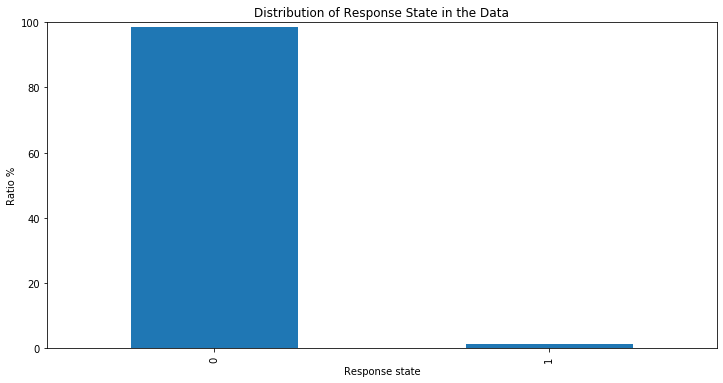

In [36]:
(target['RESPONSE'].value_counts()/target['RESPONSE'].shape[0]*100).plot(kind='bar', figsize=(12,6))
plt.ylim((0, 100))
plt.xlabel('Response state')
plt.ylabel('Ratio %')
plt.title('Distribution of Response State in the Data')
plt.show()

Applying the trained clusterer to to data to find the categories of the ob servations

In [37]:
mailout_train_scaled, mailout_train_preprocessed, scale = preprocess_data(mailout_train_clean, attr_mapping_clean, train=False, scaler=scaler)

Filtering qualitative features:
Removing qualitative features with granularity higher then 10
Categorizing qualitative features:


[========================================================================] 100%


Standardizing data:


In [38]:
mailout_train_clusters = k_means_selected.predict(mailout_train_scaled)

Computing label assignment and total inertia


In [39]:
mailout_train_preprocessed['Clusters'] = mailout_train_clusters

Analysing the clusters

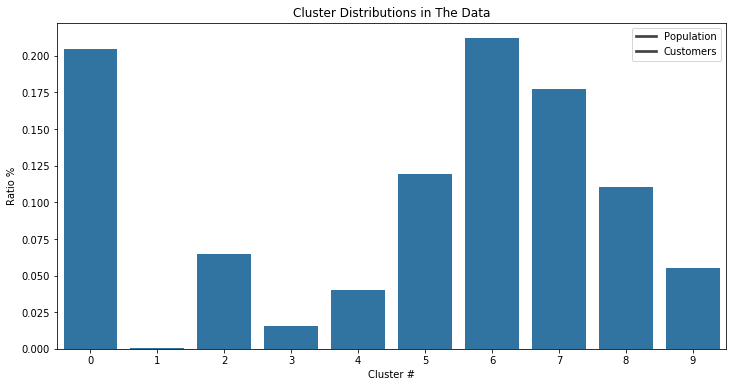

In [42]:
cluster_ratio = mailout_train_preprocessed['Clusters'].value_counts()/mailout_train_preprocessed.shape[0]
base_color = sns.color_palette()[0]

plt.figure(figsize=(12,6))
sns.barplot(cluster_ratio.index, cluster_ratio, color=base_color)
plt.legend(('Population', 'Customers'));
plt.title(('Cluster Distributions in The Data'));
plt.xlabel('Cluster #');
plt.ylabel('Ratio %');
plt.show()

The data consists mostly of observeations from clusters 6, 0 and 7

Investigating the target variable distribution in the clusters

In [43]:
clustered_target = target.join(mailout_train_preprocessed['Clusters'])
target_cluster_ratio = clustered_target[clustered_target['RESPONSE']==1]['Clusters'].value_counts()/mailout_train_preprocessed['Clusters'].value_counts()*100

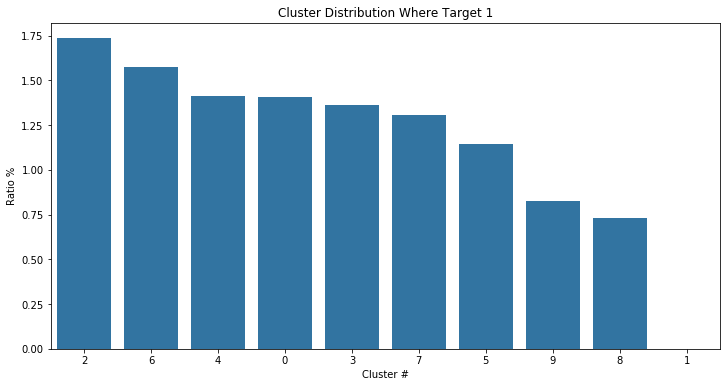

In [44]:
plt.figure(figsize=(12,6))
sns.barplot(target_cluster_ratio.index, target_cluster_ratio, order=target_cluster_ratio.sort_values(ascending=False).index, color=base_color)
plt.title(('Cluster Distribution Where Target 1'));
plt.xlabel('Cluster #');
plt.ylabel('Ratio %');
plt.show()

From the clustering analysis results, it was seen that the customers population was discribed by mainly clusters 6,0 and 7. From the above plot it can be seen that cluster 2 has the most target achived ratio. This is followed by cljster 6 with a 10% difference.

Preparing the training and testing datasets for supervised learning

Initially the variables are reduced so that the supervised machine learning model output improves

In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix

In [46]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_preprocessed, target, stratify=target, test_size=0.2)

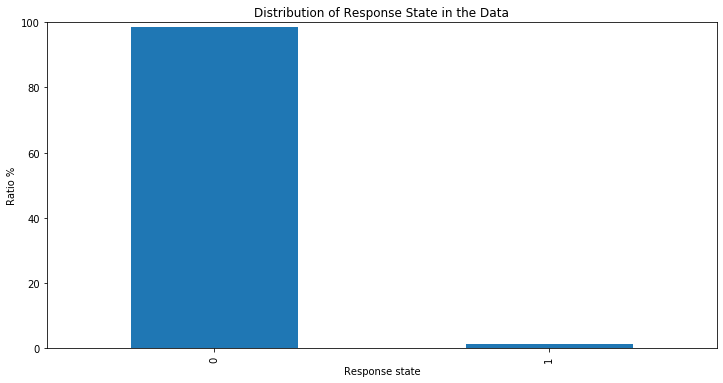

In [47]:
(y_train['RESPONSE'].value_counts()/y_train['RESPONSE'].shape[0]*100).plot(kind='bar', figsize=(12,6))
plt.ylim((0, 100))
plt.xlabel('Response state')
plt.ylabel('Ratio %')
plt.title('Distribution of Response State in the Data')
plt.show()

To get a better training set, the training data reduced with the target state of 0's.

In [48]:
y_train_0 = y_train[y_train['RESPONSE']==0].sample(y_train[y_train['RESPONSE']==1].shape[0])
y_train_1 = y_train[y_train['RESPONSE']==1]
y_train_modified = pd.concat([y_train_0, y_train_1])
X_train_modified = X_train.loc[y_train_modified.index]

In [49]:
pipeline = Pipeline([('scaler', StandardScaler()),
    ('Selector', SelectKBest()),
    ('clf', KNeighborsClassifier())
    ])

In [59]:
parameters = {
        'Selector__k': [10, 25, 50, 75, 100, 150],
        'clf__n_neighbors': [2, 4, 6, 10, 15],
        }
    
model = GridSearchCV(pipeline, param_grid=parameters, n_jobs=1, verbose=10, cv=5)
model.fit(X_train_modified.values, y_train_modified.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] Selector__k=10, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=2, score=0.483, total=   0.1s
[CV] Selector__k=10, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=2, score=0.538, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=2, score=0.429, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=2, score=0.529, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=2, score=0.479, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=4 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   53   55   64   65   66   67   69   75  132  133  134  138
  140  141  143  152  153  154  155  162  163  164  165  167  168  178
  219  221  222  228  229  273  275  278  279  290  398  614  620  626
  632  638  644  650  656  662  668  686  704  716  722  734  758  764
  770  776  782  788  794  800  806  812  818  824  830  836  842  848
  854  860  866  872  878  884  888  889  890  896  902  914  930  931
  932  938  944  950  956  960  961  965  976  977  978 1002 1014 1050
 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133
 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1254
 1262 1263 1264 1265 1266 1272 1293 1446 1447 1448 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/li

[CV] .. Selector__k=10, clf__n_neighbors=4, score=0.492, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=4, score=0.521, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=4, score=0.420, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=4, score=0.496, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=4, score=0.487, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=6, score=0.467, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=6, score=0.521, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=6 ..............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   44   46   57   64   65   66   67   69   77  132  133  134  138
  140  141  142  143  152  153  154  155  162  163  164  165  167  168
  219  220  221  222  227  228  229  273  275  276  278  279  290  398
  614  620  626  632  638  644  650  656  662  668  686  704  716  722
  734  758  764  770  776  782  788  794  800  806  812  818  824  830
  836  842  848  854  860  866  872  878  884  888  889  890  896  902
  914  930  931  932  938  944  950  956  960  961  965  976  977  978
 1002 1014 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115
 1121 1127 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217
 1223 1235 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462 1473] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udaci

[CV] .. Selector__k=10, clf__n_neighbors=6, score=0.412, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=6, score=0.487, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=10, clf__n_neighbors=6, score=0.487, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=10 .............................
[CV] . Selector__k=10, clf__n_neighbors=10, score=0.483, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=10 .............................
[CV] . Selector__k=10, clf__n_neighbors=10, score=0.546, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=10 .............................
[CV] . Selector__k=10, clf__n_neighbors=10, score=0.420, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=10 .............................
[CV] . Selector__k=10, clf__n_neighbors=10, score=0.496, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=10 .............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   64   65   66   67   69   70  132  133  134  138  140  141
  143  152  153  154  155  162  163  164  165  167  168  169  219  221
  222  228  229  273  275  278  279  290  398  614  620  626  632  638
  644  650  656  662  668  686  704  716  722  734  754  758  764  770
  776  782  788  794  800  806  812  818  824  830  836  842  848  854
  860  866  872  878  884  888  889  890  896  902  914  930  931  932
  938  944  950  956  960  961  965  976  977  978 1002 1014 1050 1056
 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133 1139
 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1246 1254
 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWa

[CV] . Selector__k=10, clf__n_neighbors=10, score=0.454, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=15 .............................
[CV] . Selector__k=10, clf__n_neighbors=15, score=0.525, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=15 .............................
[CV] . Selector__k=10, clf__n_neighbors=15, score=0.529, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=15 .............................
[CV] . Selector__k=10, clf__n_neighbors=15, score=0.403, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=15 .............................
[CV] . Selector__k=10, clf__n_neighbors=15, score=0.504, total=   0.0s
[CV] Selector__k=10, clf__n_neighbors=15 .............................
[CV] . Selector__k=10, clf__n_neighbors=15, score=0.445, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=2, score=0.475, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=2 ..............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   44   46   57   64   65   66   67   69   77  132  133  134  138
  140  141  142  143  152  153  154  155  162  163  164  165  167  168
  219  220  221  222  227  228  229  273  275  276  278  279  290  398
  614  620  626  632  638  644  650  656  662  668  686  704  716  722
  734  758  764  770  776  782  788  794  800  806  812  818  824  830
  836  842  848  854  860  866  872  878  884  888  889  890  896  902
  914  930  931  932  938  944  950  956  960  961  965  976  977  978
 1002 1014 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115
 1121 1127 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217
 1223 1235 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462 1473] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selecti

[CV] .. Selector__k=25, clf__n_neighbors=2, score=0.487, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=2, score=0.504, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=2, score=0.471, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=2, score=0.479, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=4, score=0.458, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=4, score=0.496, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=4 ..............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   52   64   65   66   67   69   76  131  132  133  134  138
  139  140  141  143  152  153  154  155  162  163  164  165  166  167
  168  219  221  222  228  229  273  275  278  279  290  398  614  620
  626  632  638  644  650  656  662  668  686  704  716  722  734  758
  764  770  776  782  788  794  800  806  812  818  824  830  836  842
  848  854  860  866  872  878  884  888  889  890  896  902  914  930
  931  932  938  944  950  956  960  961  965  976  977  978 1002 1014
 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127
 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235
 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: Runt

[CV] .. Selector__k=25, clf__n_neighbors=4, score=0.479, total=   0.1s
[CV] Selector__k=25, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=4, score=0.479, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=4, score=0.403, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=6, score=0.458, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=6, score=0.513, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=6, score=0.504, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=25, clf__n_neighbors=6, score=0.521, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=6 ..............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   64   65   66   67   69   70  132  133  134  138  140  141
  143  152  153  154  155  162  163  164  165  167  168  169  219  221
  222  228  229  273  275  278  279  290  398  614  620  626  632  638
  644  650  656  662  668  686  704  716  722  734  754  758  764  770
  776  782  788  794  800  806  812  818  824  830  836  842  848  854
  860  866  872  878  884  888  889  890  896  902  914  930  931  932
  938  944  950  956  960  961  965  976  977  978 1002 1014 1050 1056
 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133 1139
 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1246 1254
 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWa

[CV] .. Selector__k=25, clf__n_neighbors=6, score=0.412, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=10 .............................
[CV] . Selector__k=25, clf__n_neighbors=10, score=0.458, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=10 .............................
[CV] . Selector__k=25, clf__n_neighbors=10, score=0.496, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=10 .............................
[CV] . Selector__k=25, clf__n_neighbors=10, score=0.496, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=10 .............................
[CV] . Selector__k=25, clf__n_neighbors=10, score=0.504, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=10 .............................
[CV] . Selector__k=25, clf__n_neighbors=10, score=0.412, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=15 .............................
[CV] . Selector__k=25, clf__n_neighbors=15, score=0.483, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=15 .............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   44   46   57   64   65   66   67   69   77  132  133  134  138
  140  141  142  143  152  153  154  155  162  163  164  165  167  168
  219  220  221  222  227  228  229  273  275  276  278  279  290  398
  614  620  626  632  638  644  650  656  662  668  686  704  716  722
  734  758  764  770  776  782  788  794  800  806  812  818  824  830
  836  842  848  854  860  866  872  878  884  888  889  890  896  902
  914  930  931  932  938  944  950  956  960  961  965  976  977  978
 1002 1014 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115
 1121 1127 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217
 1223 1235 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462 1473] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selecti

[CV] . Selector__k=25, clf__n_neighbors=15, score=0.462, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=15 .............................
[CV] . Selector__k=25, clf__n_neighbors=15, score=0.445, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=15 .............................
[CV] . Selector__k=25, clf__n_neighbors=15, score=0.454, total=   0.0s
[CV] Selector__k=25, clf__n_neighbors=15 .............................
[CV] . Selector__k=25, clf__n_neighbors=15, score=0.370, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=2, score=0.550, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=2, score=0.504, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=2 ..............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   52   64   65   66   67   69   76  131  132  133  134  138
  139  140  141  143  152  153  154  155  162  163  164  165  166  167
  168  219  221  222  228  229  273  275  278  279  290  398  614  620
  626  632  638  644  650  656  662  668  686  704  716  722  734  758
  764  770  776  782  788  794  800  806  812  818  824  830  836  842
  848  854  860  866  872  878  884  888  889  890  896  902  914  930
  931  932  938  944  950  956  960  961  965  976  977  978 1002 1014
 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127
 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235
 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: Runt

[CV] .. Selector__k=50, clf__n_neighbors=2, score=0.445, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=2, score=0.504, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=2, score=0.487, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=4, score=0.525, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=4, score=0.479, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=4, score=0.462, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=4, score=0.513, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=4 ..............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   64   65   66   67   69   70  132  133  134  138  140  141
  143  152  153  154  155  162  163  164  165  167  168  169  219  221
  222  228  229  273  275  278  279  290  398  614  620  626  632  638
  644  650  656  662  668  686  704  716  722  734  754  758  764  770
  776  782  788  794  800  806  812  818  824  830  836  842  848  854
  860  866  872  878  884  888  889  890  896  902  914  930  931  932
  938  944  950  956  960  961  965  976  977  978 1002 1014 1050 1056
 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133 1139
 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1246 1254
 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWa

[CV] .. Selector__k=50, clf__n_neighbors=4, score=0.471, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=6, score=0.492, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=6, score=0.412, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=6, score=0.496, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=6, score=0.546, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=50, clf__n_neighbors=6, score=0.487, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=10 .............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   53   55   64   65   66   67   69   75  132  133  134  138
  140  141  143  152  153  154  155  162  163  164  165  167  168  178
  219  221  222  228  229  273  275  278  279  290  398  614  620  626
  632  638  644  650  656  662  668  686  704  716  722  734  758  764
  770  776  782  788  794  800  806  812  818  824  830  836  842  848
  854  860  866  872  878  884  888  889  890  896  902  914  930  931
  932  938  944  950  956  960  961  965  976  977  978 1002 1014 1050
 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133
 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1254
 1262 1263 1264 1265 1266 1272 1293 1446 1447 1448 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116:

[CV] . Selector__k=50, clf__n_neighbors=10, score=0.500, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=10 .............................
[CV] . Selector__k=50, clf__n_neighbors=10, score=0.571, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=10 .............................
[CV] . Selector__k=50, clf__n_neighbors=10, score=0.429, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=10 .............................
[CV] . Selector__k=50, clf__n_neighbors=10, score=0.496, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=10 .............................
[CV] . Selector__k=50, clf__n_neighbors=10, score=0.445, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=15 .............................
[CV] . Selector__k=50, clf__n_neighbors=15, score=0.450, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=15 .............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   44   46   57   64   65   66   67   69   77  132  133  134  138
  140  141  142  143  152  153  154  155  162  163  164  165  167  168
  219  220  221  222  227  228  229  273  275  276  278  279  290  398
  614  620  626  632  638  644  650  656  662  668  686  704  716  722
  734  758  764  770  776  782  788  794  800  806  812  818  824  830
  836  842  848  854  860  866  872  878  884  888  889  890  896  902
  914  930  931  932  938  944  950  956  960  961  965  976  977  978
 1002 1014 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115
 1121 1127 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217
 1223 1235 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462 1473] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selecti

[CV] . Selector__k=50, clf__n_neighbors=15, score=0.504, total=   0.1s
[CV] Selector__k=50, clf__n_neighbors=15 .............................
[CV] . Selector__k=50, clf__n_neighbors=15, score=0.429, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=15 .............................
[CV] . Selector__k=50, clf__n_neighbors=15, score=0.445, total=   0.0s
[CV] Selector__k=50, clf__n_neighbors=15 .............................
[CV] . Selector__k=50, clf__n_neighbors=15, score=0.437, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=2, score=0.542, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=2, score=0.513, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=2 ..............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   52   64   65   66   67   69   76  131  132  133  134  138
  139  140  141  143  152  153  154  155  162  163  164  165  166  167
  168  219  221  222  228  229  273  275  278  279  290  398  614  620
  626  632  638  644  650  656  662  668  686  704  716  722  734  758
  764  770  776  782  788  794  800  806  812  818  824  830  836  842
  848  854  860  866  872  878  884  888  889  890  896  902  914  930
  931  932  938  944  950  956  960  961  965  976  977  978 1002 1014
 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127
 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235
 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: Runt

[CV] .. Selector__k=75, clf__n_neighbors=2, score=0.504, total=   0.1s
[CV] Selector__k=75, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=2, score=0.580, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=2 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=2, score=0.496, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=4, score=0.550, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=4, score=0.496, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=4 ..............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   52   64   65   66   67   69   76  131  132  133  134  138
  139  140  141  143  152  153  154  155  162  163  164  165  166  167
  168  219  221  222  228  229  273  275  278  279  290  398  614  620
  626  632  638  644  650  656  662  668  686  704  716  722  734  758
  764  770  776  782  788  794  800  806  812  818  824  830  836  842
  848  854  860  866  872  878  884  888  889  890  896  902  914  930
  931  932  938  944  950  956  960  961  965  976  977  978 1002 1014
 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127
 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235
 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: Runt

[CV] .. Selector__k=75, clf__n_neighbors=4, score=0.513, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=4, score=0.546, total=   0.1s
[CV] Selector__k=75, clf__n_neighbors=4 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=4, score=0.471, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=6, score=0.450, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=6, score=0.538, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=6 ..............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   52   64   65   66   67   69   76  131  132  133  134  138
  139  140  141  143  152  153  154  155  162  163  164  165  166  167
  168  219  221  222  228  229  273  275  278  279  290  398  614  620
  626  632  638  644  650  656  662  668  686  704  716  722  734  758
  764  770  776  782  788  794  800  806  812  818  824  830  836  842
  848  854  860  866  872  878  884  888  889  890  896  902  914  930
  931  932  938  944  950  956  960  961  965  976  977  978 1002 1014
 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127
 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235
 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: Runt

[CV] .. Selector__k=75, clf__n_neighbors=6, score=0.487, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=6, score=0.538, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=6 ..............................
[CV] .. Selector__k=75, clf__n_neighbors=6, score=0.462, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=10 .............................
[CV] . Selector__k=75, clf__n_neighbors=10, score=0.500, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=10 .............................
[CV] . Selector__k=75, clf__n_neighbors=10, score=0.504, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=10 .............................
[CV] . Selector__k=75, clf__n_neighbors=10, score=0.496, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=10 .............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   64   65   66   67   69   72  132  133  134  138  140  141
  143  152  153  154  155  162  163  164  165  167  168  219  221  222
  228  229  273  275  278  279  290  398  614  620  626  632  638  644
  650  656  662  668  686  704  716  722  734  758  764  770  776  782
  788  794  800  806  812  818  824  830  836  842  848  854  860  866
  872  878  884  888  889  890  896  902  914  930  931  932  938  944
  950  956  960  961  965  976  977  978 1002 1014 1050 1056 1061 1067
 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133 1139 1151 1163
 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1254 1262 1263 1264
 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid 

[CV] . Selector__k=75, clf__n_neighbors=10, score=0.504, total=   0.1s
[CV] Selector__k=75, clf__n_neighbors=10 .............................
[CV] . Selector__k=75, clf__n_neighbors=10, score=0.462, total=   0.1s
[CV] Selector__k=75, clf__n_neighbors=15 .............................
[CV] . Selector__k=75, clf__n_neighbors=15, score=0.508, total=   0.0s
[CV] Selector__k=75, clf__n_neighbors=15 .............................
[CV] . Selector__k=75, clf__n_neighbors=15, score=0.496, total=   0.1s
[CV] Selector__k=75, clf__n_neighbors=15 .............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   52   64   65   66   67   69   76  131  132  133  134  138
  139  140  141  143  152  153  154  155  162  163  164  165  166  167
  168  219  221  222  228  229  273  275  278  279  290  398  614  620
  626  632  638  644  650  656  662  668  686  704  716  722  734  758
  764  770  776  782  788  794  800  806  812  818  824  830  836  842
  848  854  860  866  872  878  884  888  889  890  896  902  914  930
  931  932  938  944  950  956  960  961  965  976  977  978 1002 1014
 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127
 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235
 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: Runt

[CV] . Selector__k=75, clf__n_neighbors=15, score=0.471, total=   0.1s
[CV] Selector__k=75, clf__n_neighbors=15 .............................
[CV] . Selector__k=75, clf__n_neighbors=15, score=0.471, total=   0.1s
[CV] Selector__k=75, clf__n_neighbors=15 .............................
[CV] . Selector__k=75, clf__n_neighbors=15, score=0.471, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=2 .............................
[CV] . Selector__k=100, clf__n_neighbors=2, score=0.550, total=   0.1s
[CV] Selector__k=100, clf__n_neighbors=2 .............................

/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   53   55   64   65   66   67   69   75  132  133  134  138
  140  141  143  152  153  154  155  162  163  164  165  167  168  178
  219  221  222  228  229  273  275  278  279  290  398  614  620  626
  632  638  644  650  656  662  668  686  704  716  722  734  758  764
  770  776  782  788  794  800  806  812  818  824  830  836  842  848
  854  860  866  872  878  884  888  889  890  896  902  914  930  931
  932  938  944  950  956  960  961  965  976  977  978 1002 1014 1050
 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133
 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1254
 1262 1263 1264 1265 1266 1272 1293 1446 1447 1448 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116:


[CV] . Selector__k=100, clf__n_neighbors=2, score=0.521, total=   0.1s
[CV] Selector__k=100, clf__n_neighbors=2 .............................
[CV] . Selector__k=100, clf__n_neighbors=2, score=0.521, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=2 .............................
[CV] . Selector__k=100, clf__n_neighbors=2, score=0.529, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=2 .............................
[CV] . Selector__k=100, clf__n_neighbors=2, score=0.437, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=4 .............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   53   55   64   65   66   67   69   75  132  133  134  138
  140  141  143  152  153  154  155  162  163  164  165  167  168  178
  219  221  222  228  229  273  275  278  279  290  398  614  620  626
  632  638  644  650  656  662  668  686  704  716  722  734  758  764
  770  776  782  788  794  800  806  812  818  824  830  836  842  848
  854  860  866  872  878  884  888  889  890  896  902  914  930  931
  932  938  944  950  956  960  961  965  976  977  978 1002 1014 1050
 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133
 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1254
 1262 1263 1264 1265 1266 1272 1293 1446 1447 1448 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116:

[CV] . Selector__k=100, clf__n_neighbors=4, score=0.575, total=   0.1s
[CV] Selector__k=100, clf__n_neighbors=4 .............................
[CV] . Selector__k=100, clf__n_neighbors=4, score=0.538, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=4 .............................
[CV] . Selector__k=100, clf__n_neighbors=4, score=0.496, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=4 .............................
[CV] . Selector__k=100, clf__n_neighbors=4, score=0.529, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=4 .............................
[CV] . Selector__k=100, clf__n_neighbors=4, score=0.420, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=6 .............................
[CV] . Selector__k=100, clf__n_neighbors=6, score=0.592, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=6 .............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   44   46   57   64   65   66   67   69   77  132  133  134  138
  140  141  142  143  152  153  154  155  162  163  164  165  167  168
  219  220  221  222  227  228  229  273  275  276  278  279  290  398
  614  620  626  632  638  644  650  656  662  668  686  704  716  722
  734  758  764  770  776  782  788  794  800  806  812  818  824  830
  836  842  848  854  860  866  872  878  884  888  889  890  896  902
  914  930  931  932  938  944  950  956  960  961  965  976  977  978
 1002 1014 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115
 1121 1127 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217
 1223 1235 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462 1473] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selecti

[CV] . Selector__k=100, clf__n_neighbors=6, score=0.513, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=6 .............................
[CV] . Selector__k=100, clf__n_neighbors=6, score=0.571, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=6 .............................
[CV] . Selector__k=100, clf__n_neighbors=6, score=0.538, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=6 .............................
[CV] . Selector__k=100, clf__n_neighbors=6, score=0.361, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=10 ............................
[CV]  Selector__k=100, clf__n_neighbors=10, score=0.533, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=10 ............................
[CV]  Selector__k=100, clf__n_neighbors=10, score=0.504, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=10 ............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   52   64   65   66   67   69   76  131  132  133  134  138
  139  140  141  143  152  153  154  155  162  163  164  165  166  167
  168  219  221  222  228  229  273  275  278  279  290  398  614  620
  626  632  638  644  650  656  662  668  686  704  716  722  734  758
  764  770  776  782  788  794  800  806  812  818  824  830  836  842
  848  854  860  866  872  878  884  888  889  890  896  902  914  930
  931  932  938  944  950  956  960  961  965  976  977  978 1002 1014
 1050 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127
 1133 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235
 1254 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: Runt

[CV]  Selector__k=100, clf__n_neighbors=10, score=0.521, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=10 ............................
[CV]  Selector__k=100, clf__n_neighbors=10, score=0.538, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=10 ............................
[CV]  Selector__k=100, clf__n_neighbors=10, score=0.395, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=15 ............................
[CV]  Selector__k=100, clf__n_neighbors=15, score=0.525, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=15 ............................
[CV]  Selector__k=100, clf__n_neighbors=15, score=0.529, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=15 ............................
[CV]  Selector__k=100, clf__n_neighbors=15, score=0.479, total=   0.0s
[CV] Selector__k=100, clf__n_neighbors=15 ............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   64   65   66   67   69   72  132  133  134  138  140  141
  143  152  153  154  155  162  163  164  165  167  168  219  221  222
  228  229  273  275  278  279  290  398  614  620  626  632  638  644
  650  656  662  668  686  704  716  722  734  758  764  770  776  782
  788  794  800  806  812  818  824  830  836  842  848  854  860  866
  872  878  884  888  889  890  896  902  914  930  931  932  938  944
  950  956  960  961  965  976  977  978 1002 1014 1050 1056 1061 1067
 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133 1139 1151 1163
 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1254 1262 1263 1264
 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid 

[CV]  Selector__k=100, clf__n_neighbors=15, score=0.555, total=   0.1s
[CV] Selector__k=100, clf__n_neighbors=15 ............................
[CV]  Selector__k=100, clf__n_neighbors=15, score=0.462, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=2 .............................
[CV] . Selector__k=150, clf__n_neighbors=2, score=0.575, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=2 .............................
[CV] . Selector__k=150, clf__n_neighbors=2, score=0.504, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=2 .............................
[CV] . Selector__k=150, clf__n_neighbors=2, score=0.546, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=2 .............................
[CV] . Selector__k=150, clf__n_neighbors=2, score=0.479, total=   0.1s
[CV] Selector__k=150, clf__n_neighbors=2 .............................
[CV] . Selector__k=150, clf__n_neighbors=2, score=0.454, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=4 .............................
[CV] .

/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   64   65   66   67   69   70  132  133  134  138  140  141
  143  152  153  154  155  162  163  164  165  167  168  169  219  221
  222  228  229  273  275  278  279  290  398  614  620  626  632  638
  644  650  656  662  668  686  704  716  722  734  754  758  764  770
  776  782  788  794  800  806  812  818  824  830  836  842  848  854
  860  866  872  878  884  888  889  890  896  902  914  930  931  932
  938  944  950  956  960  961  965  976  977  978 1002 1014 1050 1056
 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133 1139
 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1246 1254
 1262 1263 1264 1265 1266 1272 1446 1447 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWa

[CV] . Selector__k=150, clf__n_neighbors=4, score=0.496, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=6 .............................
[CV] . Selector__k=150, clf__n_neighbors=6, score=0.583, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=6 .............................
[CV] . Selector__k=150, clf__n_neighbors=6, score=0.504, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=6 .............................
[CV] . Selector__k=150, clf__n_neighbors=6, score=0.504, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=6 .............................
[CV] . Selector__k=150, clf__n_neighbors=6, score=0.521, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=6 .............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   53   55   64   65   66   67   69   75  132  133  134  138
  140  141  143  152  153  154  155  162  163  164  165  167  168  178
  219  221  222  228  229  273  275  278  279  290  398  614  620  626
  632  638  644  650  656  662  668  686  704  716  722  734  758  764
  770  776  782  788  794  800  806  812  818  824  830  836  842  848
  854  860  866  872  878  884  888  889  890  896  902  914  930  931
  932  938  944  950  956  960  961  965  976  977  978 1002 1014 1050
 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133
 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1254
 1262 1263 1264 1265 1266 1272 1293 1446 1447 1448 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116:

[CV] . Selector__k=150, clf__n_neighbors=6, score=0.445, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=10 ............................
[CV]  Selector__k=150, clf__n_neighbors=10, score=0.533, total=   0.1s
[CV] Selector__k=150, clf__n_neighbors=10 ............................
[CV]  Selector__k=150, clf__n_neighbors=10, score=0.496, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=10 ............................
[CV]  Selector__k=150, clf__n_neighbors=10, score=0.521, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=10 ............................
[CV]  Selector__k=150, clf__n_neighbors=10, score=0.454, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=10 ............................


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   53   55   64   65   66   67   69   75  132  133  134  138
  140  141  143  152  153  154  155  162  163  164  165  167  168  178
  219  221  222  228  229  273  275  278  279  290  398  614  620  626
  632  638  644  650  656  662  668  686  704  716  722  734  758  764
  770  776  782  788  794  800  806  812  818  824  830  836  842  848
  854  860  866  872  878  884  888  889  890  896  902  914  930  931
  932  938  944  950  956  960  961  965  976  977  978 1002 1014 1050
 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133
 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1254
 1262 1263 1264 1265 1266 1272 1293 1446 1447 1448 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116:

[CV]  Selector__k=150, clf__n_neighbors=10, score=0.403, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=15 ............................
[CV]  Selector__k=150, clf__n_neighbors=15, score=0.500, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=15 ............................
[CV]  Selector__k=150, clf__n_neighbors=15, score=0.454, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=15 ............................
[CV]  Selector__k=150, clf__n_neighbors=15, score=0.471, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=15 ............................
[CV]  Selector__k=150, clf__n_neighbors=15, score=0.521, total=   0.0s
[CV] Selector__k=150, clf__n_neighbors=15 ............................
[CV]  Selector__k=150, clf__n_neighbors=15, score=0.479, total=   0.0s


/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [  15   46   53   55   64   65   66   67   69   75  132  133  134  138
  140  141  143  152  153  154  155  162  163  164  165  167  168  178
  219  221  222  228  229  273  275  278  279  290  398  614  620  626
  632  638  644  650  656  662  668  686  704  716  722  734  758  764
  770  776  782  788  794  800  806  812  818  824  830  836  842  848
  854  860  866  872  878  884  888  889  890  896  902  914  930  931
  932  938  944  950  956  960  961  965  976  977  978 1002 1014 1050
 1056 1061 1067 1073 1079 1085 1091 1097 1103 1109 1115 1121 1127 1133
 1139 1151 1163 1169 1181 1187 1193 1199 1205 1211 1217 1223 1235 1254
 1262 1263 1264 1265 1266 1272 1293 1446 1447 1448 1462] are constant.
  UserWarning)
/Users/macc/opt/anaconda3/envs/udacity_env/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116:

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('Selector', SelectKBest()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=1,
             param_grid={'Selector__k': [10, 25, 50, 75, 100, 150],
                         'clf__n_neighbors': [2, 4, 6, 10, 15]},
             verbose=10)

In [60]:
model.best_params_

{'Selector__k': 150, 'clf__n_neighbors': 4}

In [61]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

confusion_mat = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(confusion_mat, index=[0, 1], columns=[0, 1])

              precision    recall  f1-score   support

           0       0.99      0.65      0.78      5620
           1       0.01      0.36      0.03        74

    accuracy                           0.64      5694
   macro avg       0.50      0.51      0.40      5694
weighted avg       0.97      0.64      0.77      5694



In [62]:
df_cm

,0,1
0,3627,1993
1,47,27


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
def equilize_train_data(X_train, y_train):
    y_train_0 = y_train[y_train['RESPONSE']==0].sample(y_train[y_train['RESPONSE']==1].shape[0]*2)
    y_train_1 = y_train[y_train['RESPONSE']==1]
    y_train_modified = pd.concat([y_train_0, y_train_1])
    X_train_modified = X_train.loc[y_train_modified.index]
    
    return X_train_modified, y_train_modified